In [1]:
#this will generate the prediction of gene value using value of another gene
#building regression models
#for the "L" shape data, try to classify data points
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor,RandomForestRegressor,GBTRegressor
from pyspark.ml.clustering import KMeans
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# start a pyspark session
if __name__ == "__main__":
    spark = SparkSession\
        .builder\
        .appName("Gene_Model")\
        .getOrCreate()

In [3]:
#load in data
clv_wus=spark.read.format("csv").option("header", "true").load("CLV_and_WUS.csv")
toc1_lhy=spark.read.format("csv").option("header", "true").load("Toc1_and_LHY.csv")
wrn1_flc=spark.read.format("csv").option("header", "true").load("VRN1_and_FLC.csv")

In [4]:
#count samples
clv_wus.count(),toc1_lhy.count(),wrn1_flc.count()

(6289, 6289, 6289)

In [5]:
clv_wus.dtypes

[('_c0', 'string'), ('AT1G26600', 'string'), ('AT2G17950', 'string')]

In [6]:
#looking at the structure of data
clv_wus.show()

+-------------+----------------+----------------+
|          _c0|       AT1G26600|       AT2G17950|
+-------------+----------------+----------------+
|GSM253153.CEL|4.78665055734008|4.06962586701132|
|GSM253154.CEL|4.91089119376911|4.15213812110932|
|GSM253155.CEL|4.61225519827648|4.15476640948232|
|GSM253156.CEL|4.56037804816467|4.45709412676275|
|GSM253157.CEL|4.43398285241038|4.03179441426592|
|GSM253158.CEL|4.47815834920338|4.07871977043084|
|GSM253159.CEL|4.57742929643525|4.08298607647644|
|GSM253160.CEL|4.60187131355049|4.18289008973031|
|GSM253161.CEL|4.59549879010856| 4.0006476710465|
|GSM253162.CEL|4.62041348908607|4.21748340667048|
|GSM253163.CEL|4.54071816463568|4.10892011331132|
|GSM253164.CEL| 4.3558480332378|4.35455142395825|
|GSM253165.CEL| 4.3208064962194|4.11975062509295|
|GSM253166.CEL|4.34410649974101|4.18824859161207|
|GSM253193.CEL|4.37284695675801|6.43232648374709|
|GSM253194.CEL|4.20709696637903|6.08447149225631|
|GSM253195.CEL|5.45665456014251|5.82270493212995|


In [7]:
#function to randomly split each experiment into train set(80%),test set(20%)
#since those values are in the same scale, it's not necessary to rescale them
#here I didn't hold out a seperate developement set from all data
#I gonna do cross validation for tuning parameters instead
def splitData(dataset):
    whole_set=dataset.toDF('experiment', 'feature','label')
    whole_set = whole_set.withColumn("label", col("label").cast(DoubleType()))
    whole_set = whole_set.withColumn("feature", col("feature").cast(DoubleType()))
    assembler = VectorAssembler(inputCols=["feature"], outputCol="feature_v")
    whole_set = assembler.transform(whole_set)
    sampled = whole_set.randomSplit([0.8, 0.2])
    train=sampled[0]
    test=sampled[1]
    return train,test

In [8]:
temp=splitData(clv_wus)

In [9]:
temp[0].show()

+-------------+----------------+----------------+------------------+
|   experiment|         feature|           label|         feature_v|
+-------------+----------------+----------------+------------------+
| GSM10445.CEL| 4.8062498082912|4.09508357751707| [4.8062498082912]|
| GSM10448.CEL|4.26989732987905| 4.1619970662013|[4.26989732987905]|
| GSM10449.CEL|4.85775174617196|4.15979122782798|[4.85775174617196]|
| GSM10451.CEL|3.89867691270387|4.36891410873028|[3.89867691270387]|
| GSM10454.CEL|4.81478785482668|4.64048126949558|[4.81478785482668]|
| GSM10457.CEL|4.82686985988382|4.11643623710604|[4.82686985988382]|
| GSM10477.CEL|4.31426390403541|4.29772427338295|[4.31426390403541]|
| GSM10478.CEL|4.31965909891737|4.19200683824902|[4.31965909891737]|
| GSM10479.CEL|4.22324582201277| 4.5564394324202|[4.22324582201277]|
| GSM10481.CEL|  4.019798970686|4.34006802489786|  [4.019798970686]|
| GSM10482.CEL|4.31762424791098| 4.0347895873055|[4.31762424791098]|
| GSM10484.CEL|4.19778740241641|4.

In [10]:
temp[0].dtypes

[('experiment', 'string'),
 ('feature', 'double'),
 ('label', 'double'),
 ('feature_v', 'vector')]

In [11]:
#linear regression
def linearRegression(dataset):
    lr = LinearRegression(featuresCol="feature_v", labelCol="label")
    train,test=splitData(dataset)
    modelEvaluator=RegressionEvaluator()
    pipeline = Pipeline(stages=[lr])
    paramGrid = ParamGridBuilder().addGrid(lr.regParam, np.arange(0.01, 0.21, 0.05)).addGrid(lr.elasticNetParam,[0,1]).build()
    crossval = CrossValidator(estimator=lr,\
                          estimatorParamMaps=paramGrid,\
                          evaluator=modelEvaluator,\
                          numFolds=10)
    cvModel = crossval.fit(train)
    cvModel = cvModel.bestModel
    #train set
    modelEvaluator.evaluate(cvModel.transform(train))
    eval_rmse_tr = RegressionEvaluator(metricName="rmse")
    eval_r2_tr = RegressionEvaluator(metricName="r2")
    rmse_tr=eval_rmse_tr.evaluate(cvModel.transform(train))
    r2_tr=eval_r2_tr.evaluate(cvModel.transform(train))
    #test set
    modelEvaluator.evaluate(cvModel.transform(test))
    eval_rmse_te = RegressionEvaluator(metricName="rmse")
    eval_r2_te= RegressionEvaluator(metricName="r2")
    rmse_te=eval_rmse_te.evaluate(cvModel.transform(test))
    r2_te=eval_r2_te.evaluate(cvModel.transform(test))
    #result
    transformed = cvModel.transform(train).select("feature_v","label", "prediction")
    rows = transformed.collect()
    return cvModel,rows, rmse_tr, r2_tr, rmse_te, r2_te

In [12]:
linearRegression(clv_wus)

(LinearRegression_4172b0d8304a6f1fce15,
 [Row(feature_v=DenseVector([4.8062]), label=4.09508357751707, prediction=4.264538413349501),
  Row(feature_v=DenseVector([4.6159]), label=4.5868974625355, prediction=4.244872078524859),
  Row(feature_v=DenseVector([4.2699]), label=4.1619970662013, prediction=4.2091341961221325),
  Row(feature_v=DenseVector([4.8578]), label=4.15979122782798, prediction=4.269858468106074),
  Row(feature_v=DenseVector([3.8987]), label=4.36891410873028, prediction=4.170787814851935),
  Row(feature_v=DenseVector([4.1416]), label=4.34792595555586, prediction=4.1958808284741815),
  Row(feature_v=DenseVector([4.8148]), label=4.64048126949558, prediction=4.2654203777367075),
  Row(feature_v=DenseVector([4.307]), label=4.42104124728696, prediction=4.212968440586751),
  Row(feature_v=DenseVector([4.8269]), label=4.11643623710604, prediction=4.266668426472698),
  Row(feature_v=DenseVector([4.3143]), label=4.29772427338295, prediction=4.213717181026892),
  Row(feature_v=Dens

In [13]:
#linearRegression(toc1_lhy)

In [14]:
#linearRegression(wrn1_flc)

In [15]:
#Decision tree regression
def decisionTreeRegression(dataset):
    dt = DecisionTreeRegressor(featuresCol="feature_v", labelCol="label")
    train,test=splitData(dataset)
    modelEvaluator=RegressionEvaluator()
    model = dt.fit(train)
    #train set
    modelEvaluator.evaluate(model.transform(train))
    eval_rmse_tr = RegressionEvaluator(metricName="rmse")
    eval_r2_tr = RegressionEvaluator(metricName="r2")
    rmse_tr=eval_rmse_tr.evaluate(model.transform(train))
    r2_tr=eval_r2_tr.evaluate(model.transform(train))
    #test set
    modelEvaluator.evaluate(model.transform(test))
    eval_rmse_te = RegressionEvaluator(metricName="rmse")
    eval_r2_te= RegressionEvaluator(metricName="r2")
    rmse_te=eval_rmse_te.evaluate(model.transform(test))
    r2_te=eval_r2_te.evaluate(model.transform(test))
    #prediction result
    transformed = model.transform(train).select("feature_v","label", "prediction")
    rows = transformed.collect()
    return model,rows, rmse_tr, r2_tr, rmse_te, r2_te

In [16]:
decisionTreeRegression(clv_wus)

(DecisionTreeRegressionModel (uid=DecisionTreeRegressor_4671a04cb9535642f6ee) of depth 5 with 37 nodes,
 [Row(feature_v=DenseVector([4.8062]), label=4.09508357751707, prediction=4.236781552423831),
  Row(feature_v=DenseVector([4.6159]), label=4.5868974625355, prediction=4.414656773788904),
  Row(feature_v=DenseVector([4.2699]), label=4.1619970662013, prediction=4.225694059594219),
  Row(feature_v=DenseVector([4.8578]), label=4.15979122782798, prediction=4.320017148668279),
  Row(feature_v=DenseVector([4.8148]), label=4.64048126949558, prediction=4.320017148668279),
  Row(feature_v=DenseVector([4.8269]), label=4.11643623710604, prediction=4.320017148668279),
  Row(feature_v=DenseVector([4.8508]), label=3.98512494445831, prediction=4.320017148668279),
  Row(feature_v=DenseVector([4.2232]), label=4.5564394324202, prediction=4.176767002818548),
  Row(feature_v=DenseVector([4.1625]), label=4.12662277727793, prediction=4.176767002818548),
  Row(feature_v=DenseVector([4.0198]), label=4.340068

In [17]:
#decisionTreeRegression(toc1_lhy)

In [18]:
#decisionTreeRegression(wrn1_flc)

In [19]:
#Random forest regression
def randomForestRegression(dataset):
    rf = RandomForestRegressor(maxDepth=5, seed=42,featuresCol="feature_v", labelCol="label")
    train,test=splitData(dataset)
    modelEvaluator=RegressionEvaluator()
    pipeline = Pipeline(stages=[rf])
    paramGrid = ParamGridBuilder().addGrid(rf.numTrees, np.arange(1, 10, 1)).addGrid(rf.subsamplingRate,[0.5,0.75,1]).build()
    crossval = CrossValidator(estimator=rf,\
                          estimatorParamMaps=paramGrid,\
                          evaluator=modelEvaluator,\
                          numFolds=10)
    cvModel = crossval.fit(train)
    cvModel = cvModel.bestModel
    #train set
    modelEvaluator.evaluate(cvModel.transform(train))
    eval_rmse_tr = RegressionEvaluator(metricName="rmse")
    eval_r2_tr = RegressionEvaluator(metricName="r2")
    rmse_tr=eval_rmse_tr.evaluate(cvModel.transform(train))
    r2_tr=eval_r2_tr.evaluate(cvModel.transform(train))
    #test set
    modelEvaluator.evaluate(cvModel.transform(test))
    eval_rmse_te = RegressionEvaluator(metricName="rmse")
    eval_r2_te= RegressionEvaluator(metricName="r2")
    rmse_te=eval_rmse_te.evaluate(cvModel.transform(test))
    r2_te=eval_r2_te.evaluate(cvModel.transform(test))
    #prediction result
    transformed = cvModel.transform(train).select("feature_v","label", "prediction")
    rows = transformed.collect()
    return cvModel,rows, rmse_tr, r2_tr, rmse_te, r2_te

In [20]:
randomForestRegression(clv_wus)

(RandomForestRegressionModel (uid=RandomForestRegressor_4ca8baf3b5f79a8ce78e) with 6 trees,
 [Row(feature_v=DenseVector([4.8062]), label=4.09508357751707, prediction=4.299793352951372),
  Row(feature_v=DenseVector([4.6159]), label=4.5868974625355, prediction=4.4253691134911195),
  Row(feature_v=DenseVector([4.2699]), label=4.1619970662013, prediction=4.24754724821321),
  Row(feature_v=DenseVector([4.8578]), label=4.15979122782798, prediction=4.264249925991844),
  Row(feature_v=DenseVector([3.8987]), label=4.36891410873028, prediction=3.918272157551367),
  Row(feature_v=DenseVector([4.1416]), label=4.34792595555586, prediction=4.168805606156732),
  Row(feature_v=DenseVector([4.8148]), label=4.64048126949558, prediction=4.299793352951372),
  Row(feature_v=DenseVector([4.307]), label=4.42104124728696, prediction=4.319340785365772),
  Row(feature_v=DenseVector([4.8269]), label=4.11643623710604, prediction=4.264249925991844),
  Row(feature_v=DenseVector([4.3143]), label=4.29772427338295, pr

In [21]:
#randomForestRegression(toc1_lhy)

In [22]:
#randomForestRegression(wrn1_flc)

In [23]:
#Gradient-boosted tree regression
def gradientBoostedRegression(dataset):
    gbt = GBTRegressor(featuresCol="feature_v", labelCol="label")
    train,test=splitData(dataset)
    modelEvaluator=RegressionEvaluator()
    model = gbt.fit(train)
    #train set
    modelEvaluator.evaluate(model.transform(train))
    eval_rmse_tr = RegressionEvaluator(metricName="rmse")
    eval_r2_tr = RegressionEvaluator(metricName="r2")
    rmse_tr=eval_rmse_tr.evaluate(model.transform(train))
    r2_tr=eval_r2_tr.evaluate(model.transform(train))
    #test set
    modelEvaluator.evaluate(model.transform(test))
    eval_rmse_te = RegressionEvaluator(metricName="rmse")
    eval_r2_te= RegressionEvaluator(metricName="r2")
    rmse_te=eval_rmse_te.evaluate(model.transform(test))
    r2_te=eval_r2_te.evaluate(model.transform(test))
    #prediction result
    transformed = model.transform(train).select("feature_v","label", "prediction")
    rows = transformed.collect()
    return model,rows,rmse_tr, r2_tr, rmse_te, r2_te

In [24]:
gradientBoostedRegression(clv_wus)

(GBTRegressionModel (uid=GBTRegressor_4c52b40ec49adf86092b) with 20 trees,
 [Row(feature_v=DenseVector([4.6159]), label=4.5868974625355, prediction=4.4189199055399015),
  Row(feature_v=DenseVector([4.2699]), label=4.1619970662013, prediction=4.221989849973209),
  Row(feature_v=DenseVector([4.8578]), label=4.15979122782798, prediction=4.331096366391956),
  Row(feature_v=DenseVector([3.8987]), label=4.36891410873028, prediction=3.8962242254433117),
  Row(feature_v=DenseVector([4.1416]), label=4.34792595555586, prediction=4.1821094250019275),
  Row(feature_v=DenseVector([4.307]), label=4.42104124728696, prediction=4.363534077699852),
  Row(feature_v=DenseVector([4.8269]), label=4.11643623710604, prediction=4.331096366391956),
  Row(feature_v=DenseVector([4.8508]), label=3.98512494445831, prediction=4.331096366391956),
  Row(feature_v=DenseVector([4.3143]), label=4.29772427338295, prediction=4.363534077699852),
  Row(feature_v=DenseVector([4.3197]), label=4.19200683824902, prediction=4.363

In [25]:
#gradientBoostedRegression(toc1_lhy)

In [26]:
#gradientBoostedRegression(wrn1_flc)

In [27]:
#detecting the "L" shape by clustering them
def kmeans(dataset):
    whole_set=dataset.toDF('experiment', 'feature','label')
    whole_set = whole_set.withColumn("label", col("label").cast(DoubleType()))
    whole_set = whole_set.withColumn("feature", col("feature").cast(DoubleType()))
    assembler = VectorAssembler(inputCols=["feature",'label'], outputCol="features")
    whole_set = assembler.transform(whole_set)
    kmeans = KMeans(k=3, seed=1)
    model = kmeans.fit(whole_set)
    transformed = model.transform(whole_set).select("features", "prediction")
    rows = transformed.collect()
    return rows

In [28]:
rows=kmeans(clv_wus)

In [29]:
cluster_result=pd.DataFrame(columns=['AT1G26600', 'AT2G17950', 'cluster'])
i=0
for row in rows:
    cluster_result.loc[i]=[row.features[0],row.features[1],row.prediction]
    i+=1
cluster_result.head()

,AT1G26600,AT2G17950,cluster
0,4.786651,4.069626,0.0
1,4.910891,4.152138,0.0
2,4.612255,4.154766,2.0
3,4.560378,4.457094,2.0
4,4.433983,4.031794,2.0


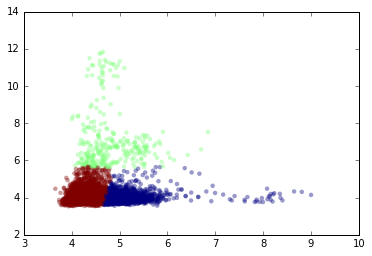

In [30]:
plt.scatter(cluster_result["AT1G26600"], cluster_result["AT2G17950"], c=cluster_result["cluster"], alpha=0.4, lw=0)
plt.show()

In [31]:
#comparing regression result on three pairs of genes
def regressionResult(dataset):
    lr_rows=linearRegression(dataset)[1]
    dt_rows=decisionTreeRegression(dataset)[1]
    rf_rows=randomForestRegression(dataset)[1]
    gbt_rows=gradientBoostedRegression(dataset)[1]
    reg_result=pd.DataFrame(columns=['gene1', 'gene2', 'Linear','DecisionTree','RandomForest','GradientBoosted'])
    for i in range(0,min(len(lr_rows),len(dt_rows),len(rf_rows),len(gbt_rows))):
        lr_row=lr_rows[i]
        dt_row=dt_rows[i]
        rf_row=rf_rows[i]
        gbt_row=gbt_rows[i]
        reg_result.loc[i]=[lr_row.feature_v[0],lr_row.label,lr_row.prediction,dt_row.prediction,rf_row.prediction,gbt_row.prediction]
    return reg_result

In [32]:
regression_result=regressionResult(clv_wus)

In [33]:
def regressionPlots(regression_result):
    fig, ax = plt.subplots(figsize=(15,15), nrows=2, ncols=2)
    for i in range(0,2):
        for j in range(0,2):
            ax[i][j].scatter(regression_result["gene1"], regression_result["gene2"], alpha=0.4, lw=0)

    ax[0][0].plot(regression_result["gene1"], regression_result["Linear"], c="red")
    ax[0][1].scatter(regression_result["gene1"], regression_result["DecisionTree"], c="yellow",alpha=0.4, lw=0)
    ax[1][0].scatter(regression_result["gene1"], regression_result["RandomForest"], c="green",alpha=0.4, lw=0)
    ax[1][1].scatter(regression_result["gene1"], regression_result["GradientBoosted"], c="grey",alpha=0.4, lw=0)
    plt.show()

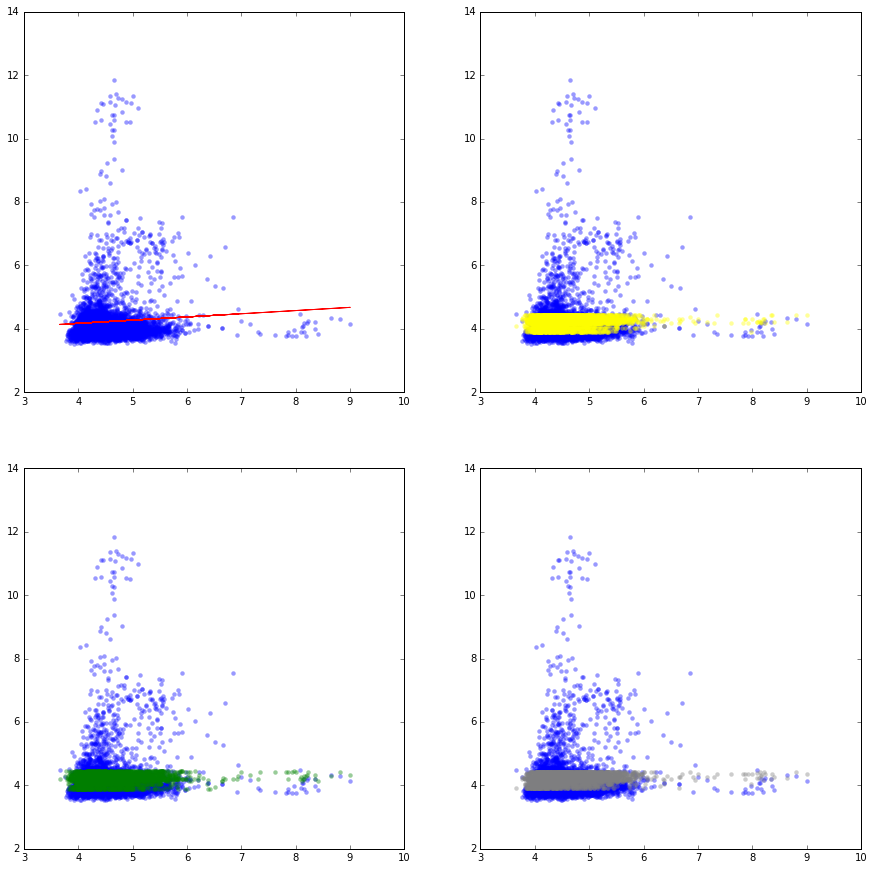

In [34]:
regressionPlots(regression_result)

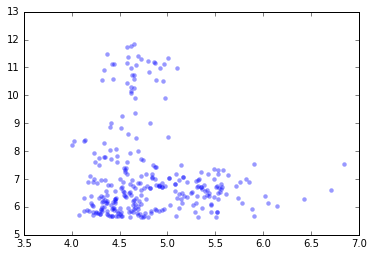

In [35]:
remove_one_cluster=cluster_result.loc[cluster_result['cluster'] == 1]
plt.scatter(remove_one_cluster["AT1G26600"], remove_one_cluster["AT2G17950"], alpha=0.4, lw=0)
plt.show()

In [36]:
remove_one_cluster = spark.createDataFrame(remove_one_cluster)
remove_one_cluster = remove_one_cluster.toDF('feature','label','cluster')
remove_one_cluster = remove_one_cluster.select('cluster','feature','label')
remove_one_cluster

DataFrame[cluster: double, feature: double, label: double]

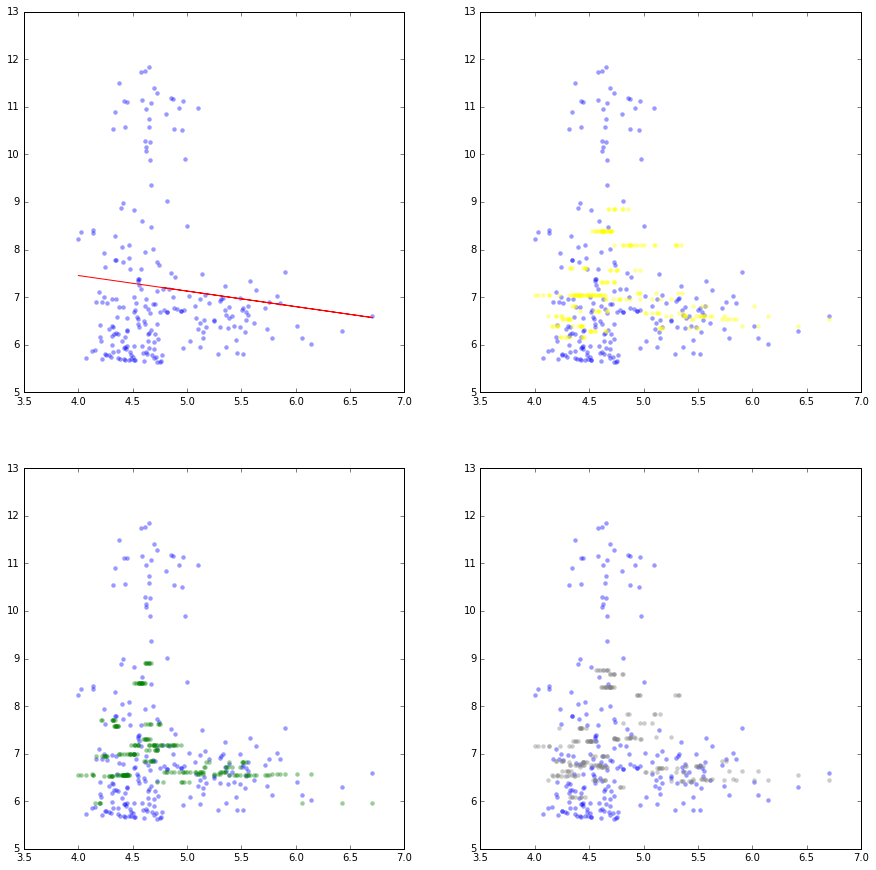

In [37]:
regression_result_1=regressionResult(remove_one_cluster)
regressionPlots(regression_result_1)

In [38]:
reg_compare = pd.DataFrame(columns=('pair','model','Train-RMSE','Train-R2','Test-RMSE','Test-R2'))
lr_temp=[linearRegression(clv_wus)[2:6],linearRegression(toc1_lhy)[2:6],linearRegression(wrn1_flc)[2:6]]
dt_temp=[decisionTreeRegression(clv_wus)[2:6],decisionTreeRegression(toc1_lhy)[2:6],decisionTreeRegression(wrn1_flc)[2:6]]
rf_temp=[randomForestRegression(clv_wus)[2:6],randomForestRegression(toc1_lhy)[2:6],randomForestRegression(wrn1_flc)[2:6]]
gd_temp=[gradientBoostedRegression(clv_wus)[2:6],gradientBoostedRegression(toc1_lhy)[2:6],gradientBoostedRegression(wrn1_flc)[2:6]]

In [39]:
lr_temp

[(0.7805357926735198,
  0.005193354488295943,
  0.7963283043071635,
  0.0002832473231184629),
 (1.4965406137346366,
  0.2833255656069107,
  1.5389238030020957,
  0.2506914155871558),
 (1.5495429650419141,
  0.001215558391393201,
  1.587084718933663,
  -0.00022856144494798336)]

In [40]:
dt_temp

[(0.7764441295213701,
  0.024423872241347233,
  0.7726272265172502,
  0.024704559945666227),
 (1.489663626351897,
  0.28430340060873205,
  1.5093175949112962,
  0.3010443771294533),
 (1.506450153505039,
  0.04837052638504824,
  1.576536431933223,
  0.044980597139085976)]

In [41]:
rf_temp

[(0.7711613557021675,
  0.02858983245392044,
  0.7936833534697486,
  0.007416306751539481),
 (1.4863526766458497,
  0.2857274770635767,
  1.5247523444518298,
  0.29629104099253456),
 (1.5107371828734666,
  0.048585092542480224,
  1.5602056087035518,
  0.038664420533775834)]

In [42]:
gd_temp

[(0.7600323029663143,
  0.027556420818286353,
  0.833990140216175,
  0.014955474786584988),
 (1.49037293271156, 0.2976851018305783, 1.504811697656041, 0.2465461023584261),
 (1.5192792494490708,
  0.053572782424701426,
  1.5229519948425705,
  0.024289978551227054)]

In [45]:
linearRegression(remove_one_cluster)[2:6]

(1.5682948622313686,
 0.016844382089359455,
 1.552649139067067,
 -0.028932325164580552)

In [46]:
decisionTreeRegression(remove_one_cluster)[2:6]

(1.3565003553930832,
 0.13004106391602432,
 2.018628090421832,
 -0.013123545323859176)

In [47]:
randomForestRegression(remove_one_cluster)[2:6]

(1.4458583044984565,
 0.22332694763492789,
 1.6321888550315866,
 -0.7075745900349519)

In [48]:
gradientBoostedRegression(remove_one_cluster)[2:6]

(1.407794203949849,
 0.17875400553086296,
 1.6557004058562983,
 -0.01652968482109274)